In [17]:
import polars as pl
import os


dfs = []
for folder in os.listdir("logs"):
    if not os.path.isdir(os.path.join("logs", folder)):
        continue
    _, delay_str, _, seed_str = folder.split("-")
    delay = int(delay_str)
    seed = int(seed_str)
    dfs.append(pl.read_csv(os.path.join("logs", folder, "train.csv")).with_columns(
        pl.lit(delay).alias("delay"),
        pl.lit(seed).alias("seed")
    ))
df: pl.DataFrame = pl.concat(dfs)
df = df.with_columns(((pl.col("time_step") / 5000).round(0) * 5000).cast(pl.Int64).alias("step_num"))
df = df.sort(by="time_step")
df

step_num,score,ep_num,epsilon,exit_rate,option_0_avg_length,option_0_active,option_1_avg_length,option_1_active,timestamp_sec,time_step,delay,seed
i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,i64,i32,i32
0,0.0,48,0.999107,0.0,2.888889,0.541667,1.5,0.4375,1.7569e9,48,100,8
0,0.0,48,0.999107,0.0,1.555556,0.291667,3.0,0.6875,1.7569e9,48,3,8
0,0.0,48,0.999107,0.0,1.866667,0.583333,1.9,0.395833,1.7569e9,48,2,4
0,0.0,48,0.999107,0.0,3.125,0.520833,2.1,0.4375,1.7569e9,48,2,3
0,0.0,48,0.999107,0.0,1.2,0.125,2.625,0.4375,1.7569e9,48,100,1
…,…,…,…,…,…,…,…,…,…,…,…,…
200000,4.0,41,0.05,1.0,29.0,0.707317,0.0,0.0,1.7569e9,200030,1,2
200000,4.0,37,0.05,1.0,0.0,0.0,0.0,0.0,1.7569e9,200031,0,1
200000,4.0,39,0.05,1.0,0.0,0.0,0.0,0.0,1.7569e9,200034,0,7


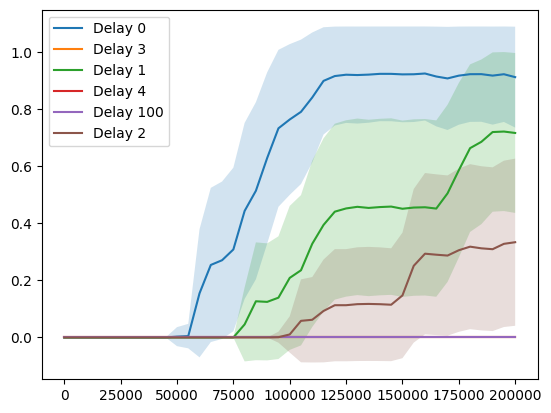

In [21]:
import matplotlib.pyplot as plt

n_repetitions = df["seed"].n_unique()
for (name, *_), by_delay in df.group_by("delay"):
    stats = by_delay.group_by("step_num").agg([
        pl.mean("exit_rate").alias("mean"),
        pl.std("exit_rate").alias("std")
    ]).sort("step_num").select(["step_num", "mean", "std"])
    plt.plot(stats["step_num"], stats["mean"], label=f"Delay {name}")
    ci95 = stats["std"] * 1.96 / (n_repetitions**0.5)
    plt.fill_between(stats["step_num"], stats["mean"] - ci95, stats["mean"] + ci95, alpha=0.2)
plt.legend()
